In [87]:
import numpy as onp
import jax
import jax.numpy as jnp
import diffrax as dx
import equinox as eqx
import matplotlib.pyplot as plt
import jax.tree_util as jtu
from jaxtyping import Array, Int, Float
from typing import Tuple
import ete3

import phylax.message as msg
from gcdyn import bdms, mutators, poisson

In [86]:
class MTBDmessenger(msg.Messenger):
    fr"""A callable Pytree that computes the message received at a node, given its features
    and the representations of its children.

    Multi-type birth-death process with sampling and fossilization. Assume
    :math:`d\in\mathbb{N}_0` types.

    Args:
        λ: Birth rates for each of :math:`d` states.
        μ: Death rates for each of :math:`d` states.
        Γ: :math:`d \times d` transition rate matrix, modeling mutation between states.
           It should have zero entries on the diagonal, and non-negative entries elsewhere.
        σ: Sampling probability :math:`\in [0, 1]`.
        ρ: Fossilization probability :math:`\in [0, 1]`.
    """
    λ: Float[Array, " d"]
    μ: Float[Array, " d"]
    Γ: Float[Array, "d d"]
    σ: Float
    ρ: Float
    def __init__(self, λ, μ, Γ, σ, ρ):
        self.null_value = 0.0
        self.λ = λ
        self.μ = μ
        self.Γ = Γ
        self.σ = σ
        self.ρ = ρ

    def __call__(self, child_representations: ???, parent_features: Tuple[int, float, float]) -> ???:
        parent_type = parent_features[0]
        parent_branch_len = parent_features[1]
        parent_time = parent_features[2]
        child_pqs = child_representations[:, 1:3]
        child_branch_lens = child_representations[:, 2]
        child_times = child_representations[:, 3]
        
        branch_propagator = self.g(parent_time, parent_time + parent_branch_len, child_representations, (self.λ, self.μ, self.Γ, self.σ))


    @staticmethod
    @jax.jit
    def f(t: Float, pq: Float[Array, "d 2"], args):
        λ, μ, Γ, σ = args
        γ = jnp.sum(Γ, axis=1)
        p = pq[:, 0]
        q = pq[:, 1]
        dpdt = -(λ + μ + γ) * p + μ * (1 - σ) + λ * p ** 2 + Γ @ p
        dqdt = -(λ + μ + γ) * q + 2 * λ * q * p
        return jnp.stack([dpdt, dqdt], axis=1)
    
    @eqx.filter_jit
    def g(self, t0: Float, t1: Float, pq0: Float[Array, "d 2"]):
        solution = dx.diffeqsolve(dx.ODETerm(self.f),
                                  dx.Dopri5(),
                                  args=(self.λ, self.μ, self.Γ, self.σ),
                                  y0=pq0,
                                  t0=t0, t1=t1, dt0=(t1 - t0) / 10)
        return solution.ys[-1]

In [76]:
class MTBDmodel(eqx.Module):
    """TODO: docstring"""
    term: dx.ODETerm
    # tree_message_passer: msg.TreeMessagePasser
    def __init__(self, tree: ete3.TreeNode,
                 λ: Float[Array, " d"],
                 μ: Float[Array, " d"],
                 Γ: Float[Array, "d d"],
                 ρ: Float,
                 σ: Float):
        self.term = dx.ODETerm(self.f)
        # self.tree_message_passer =  msg.TreeMessagePasser(...)

# NOTE: need to initialize ps, as Thanasi notes

In [77]:
key = jax.random.PRNGKey(0)

In [78]:
d = 10
λ = jnp.logspace(-1, 1, d)
μ = jnp.logspace(-1, 1, d)
Γ = jnp.exp(jax.random.normal(key, shape=(d, d))) * (1 - jnp.eye(d))
ρ = 0.5
σ = 0.1

In [79]:
pq0 = jnp.ones((d, 2))

In [80]:
model = MTBDmodel(0, 0, 0, 0, 0, 0)

args = (λ, μ, Γ, σ)
t0 = 0
t1 = 1

pq1 = model.g(t0, t1, pq0, args)

pq1

Array([[8.29602514e-01, 2.43124057e-08],
       [8.35744087e-01, 3.35012161e-04],
       [8.33196781e-01, 3.22841131e-05],
       [8.32552500e-01, 2.38935633e-07],
       [8.31213660e-01, 1.81156385e-06],
       [8.23096005e-01, 4.05979706e-04],
       [8.22503734e-01, 3.01066380e-08],
       [8.14995368e-01, 6.10820877e-06],
       [8.10508707e-01, 1.01537908e-07],
       [8.02975648e-01, 5.90008834e-06]], dtype=float64, weak_type=True)

In [ ]:
birth_rate = poisson.SigmoidResponse(xscale=3.0, xshift=0.4, yscale=4, yshift=0.0)
death_rate = poisson.ConstantResponse(0.8)
mutation_rate = poisson.ConstantResponse(1.1)
mutator = mutators.GaussianMutator(shift=-0.1, scale=0.1)

In [117]:
d = 10
λ = jnp.ones(d)
# λ = jnp.logspace(-1, 1, d)
μ = 2 * λ
# μ = jnp.logspace(-1, 1, d)
Γ = jnp.exp(jax.random.normal(key, shape=(d, d))) * (1 - jnp.eye(d))
ρ = 0.5
σ = 0.1

In [118]:
def f(t, p, args):
    λ, μ, γ, Γ, σ = args
    γ = jnp.sum(Γ, axis=1)
    return -(λ + μ + γ) * p + μ * (1 - σ) + λ * p ** 2 + Γ @ p

Some times we want to evaluate the solution at (i.e. tree leaves)

In [119]:
t = jnp.linspace(0, 10, 100)

In [120]:
term = dx.ODETerm(f)
solver = dx.Dopri5()
p0 = (1 - ρ) * jnp.ones(d)
solution = dx.diffeqsolve(term, solver,
                          args=(λ, μ, γ, Γ, σ),
                          y0=p0,
                          t0=t[0], t1=t[-1], dt0=0.1, saveat=dx.SaveAt(ts=t))

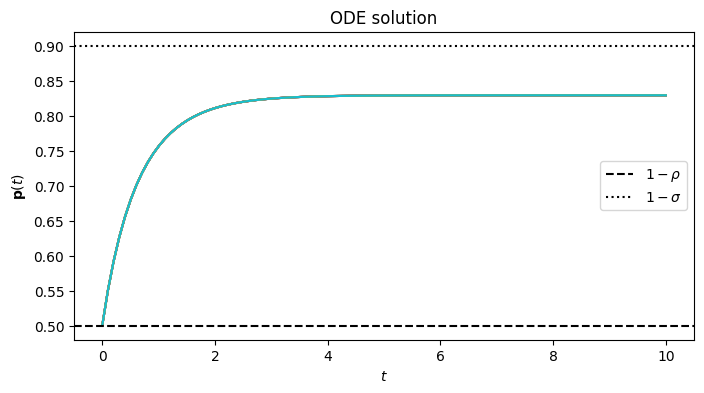

In [121]:
# plot solution
plt.figure(figsize=(8, 4))
plt.plot(t, solution.ys)
plt.axhline(1 - ρ, color='k', linestyle='--', label=r'$1-\rho$')
plt.axhline(1 - σ, color='k', linestyle=':', label=r'$1-\sigma$')
plt.legend()
plt.xlabel('$t$')
plt.ylabel(r'$\mathbf{p}(t)$')
plt.title('ODE solution')
plt.show()